# Selecting high quality receptors
- using matrix multiplications for filtering out receptors
- filtered consensus signature and design matrix are saved to lincs_consensus/hq_newfilter/lm_all_pert_cell_liana_transp.csv and design_matrices/hq_newfilter/all_pert_binary_liana.csv
- filtering out shRNA and CRISPR
- filtering out also inhibitory drugs - all interaction will be positive

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import *
from src.prediction_functions import *
from src.model_creation import *
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc


In [114]:
from src.model_creation import fit_lasso_model_and_get_coefficients


# Fit model on high quality receptors

In [115]:
dms = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)
data = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col = 0)

In [116]:
data.shape, dms.shape

((14463, 978), (14463, 229))

In [117]:
coeff_m = fit_lasso_model_and_get_coefficients(y = data, X = dms, alpha = 0.01)

 14%|█▎        | 134/978 [00:03<00:24, 34.15it/s]


KeyboardInterrupt: 

In [109]:
def save_coeffitient_matrix(coeff_matrix, model_name):
    path = f'data/coefficient_matrix/high_quality/{model_name}_pert_coef_liana.csv'
    print('Save coefficient matrix to '+  path)
    coeff_matrix.to_csv(path)
    print('Done')

In [110]:
# save_coeffitient_matrix(coeff_m, 'alllasso')

Save coefficient matrix to data/coefficient_matrix/high_quality/alllasso_pert_coef_liana.csv
Done


# Read in data split

In [118]:
# ridden_lasso = pd.read_csv(f'data/coefficient_matrix/high_quality/alllasso_pert_coef_liana.csv', index_col = 0)
lincs_consensus = pd.read_csv('data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col = 0)
prior_knowledge = pd.read_csv('data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)

In [119]:
# read in the same split as RIDDEN
with open('results/confidence/train_indices_229_s0.json', 'r') as f:
    train_indices_dict = json.load(f)
with open('results/confidence/test_indices_229_s0.json', 'r') as f:
    test_indices_dict = json.load(f)


In [120]:
train_indices_dict = {int(k): v for k, v in train_indices_dict.items()}
test_indices_dict = {int(k): v for k, v in test_indices_dict.items()}

In [121]:
train_sets = {}
test_sets = {}

for key in train_indices_dict.keys():
    train_sets[key] = {}
    train_sets[key]['prior_knowledge'] = prior_knowledge.loc[train_indices_dict[key]]
    train_sets[key]['lincs_consensus'] = lincs_consensus.loc[train_indices_dict[key]]
    test_sets[key] = {}
    test_sets[key]['prior_knowledge'] = prior_knowledge.loc[test_indices_dict[key]]
    test_sets[key]['lincs_consensus'] = lincs_consensus.loc[test_indices_dict[key]]

In [133]:

coeff_matrices = {}
for i in tqdm(train_sets):
    coeff_matrices[i] = fit_lasso_model_and_get_coefficients(X = train_sets[i]['prior_knowledge'], y = train_sets[i]['lincs_consensus'], alpha = 0.00001)

100%|██████████| 5/5 [16:04<00:00, 192.81s/it]


In [134]:
for i in coeff_matrices:
    coeff_matrices[i].to_csv(f'results/confidence/coeff_matrix_lasso000001_split_229_s0_{i}.csv')

In [135]:
coeff_matrices = {}
for i in train_sets:
    coeff_matrices[i] = pd.read_csv(f'results/confidence/coeff_matrix_lasso000001_split_229_s0_{i}.csv', index_col = 0)

In [136]:
# predict values with train coeff_m
# 10 min
receptor_activities = {}
for i in tqdm(coeff_matrices):
    receptor_activities[i] = estimate_receptor_activity(input_data = test_sets[i]['lincs_consensus'], lincs_model = coeff_matrices[i].T.astype(float), number_of_permutations=1000, chunk_size=300)

  0%|          | 0/5 [00:00<?, ?it/s]

Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


 20%|██        | 1/5 [02:20<09:21, 140.41s/it]

Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


 40%|████      | 2/5 [04:24<06:32, 130.91s/it]

Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


 60%|██████    | 3/5 [06:33<04:19, 129.78s/it]

Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


 80%|████████  | 4/5 [08:39<02:08, 128.53s/it]

Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


100%|██████████| 5/5 [10:49<00:00, 129.89s/it]


In [137]:
for i in receptor_activities:
    receptor_activities[i].to_csv(f'results/confidence/receptor_activities_lasso000001_split_229_s0_{i}.csv')

# MWU and ROC AUC

In [171]:
receptor_activities = {}
for i in range(0, 5):
    receptor_activities[i] = pd.read_csv(f'results/confidence/receptor_activities_lasso_split_229_s0_{i}.csv', index_col =0)

In [172]:
def create_negativ_and_positive_binary(binary):
    # print("Create positive value matrices for ROC curve calculation")

    if (binary == -1).any().any() == False:
        print('There are only positive perturbations, no negative matrix')
        negative_binary = pd.DataFrame()
    else:
        negative_binary = binary.replace({1:0})
        assert set(np.unique(negative_binary.values)) == {-1, 0}
        # delete only 0 rows
        s = negative_binary.sum() != 0
        negative_binary = negative_binary.loc[:, s.values]
        # change sign
        negative_binary = negative_binary.replace({-1:1})
        assert set(np.unique(negative_binary.values)) == {0, 1}

    if (binary == 1).any().any() == False:
        print('There are only negative perturbations, no positive matrix')
        positive_binary = pd.DataFrame()
    else: 
        positive_binary = binary.replace({-1:0})
        assert set(np.unique(positive_binary.values)) == {0, 1}
        # delete only 0 rows
        s = positive_binary.sum() != 0
        positive_binary = positive_binary.loc[:, s.values]

    return negative_binary, positive_binary

In [173]:
def calculate_rocaucs(binary, activities):
    print('Calculate ROC curves')
    receptors = list(set(activities.columns) & set(binary.columns))
    filtered_activities  = activities.loc[binary.index, receptors]
    filtered_binary = binary.loc[filtered_activities.index,receptors]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for receptor in filtered_binary.columns:
        fpr[receptor], tpr[receptor], _ = roc_curve(filtered_binary.loc[:, receptor], filtered_activities.loc[:, receptor])
        fpr[receptor] = fpr[receptor].tolist()
        tpr[receptor] = tpr[receptor].tolist()
        roc_auc[receptor] = auc(fpr[receptor], tpr[receptor])
    return fpr, tpr, roc_auc


In [174]:
def calculate_rocauc(activities, prior_knowledge):

    assert activities.shape[1] != 978
    negative_binary, positive_binary = create_negativ_and_positive_binary(prior_knowledge)
    results = {}
    if len(negative_binary) != 0:
        negative_results = {}
        negative_results['fpr'], negative_results['tpr'], negative_results['rocauc'] = calculate_rocaucs(negative_binary, activities)
        results['negative_results'] = negative_results
    if len(positive_binary) != 0:
        positive_results = {}
        positive_results['fpr'], positive_results['tpr'], positive_results['rocauc'] = calculate_rocaucs(positive_binary, activities)
        results['positive_results'] = positive_results
    # print('---- Done ----')
    return results

In [175]:

all_rocauc_results = {}
for i in tqdm(range(5)):
    results = calculate_rocauc(activities = receptor_activities[i], prior_knowledge = prior_knowledge.loc[test_indices_dict[i]])
    all_rocauc_results[i] = results

  0%|          | 0/5 [00:00<?, ?it/s]

Calculate ROC curves
Calculate ROC curves


 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

Calculate ROC curves
Calculate ROC curves


 40%|████      | 2/5 [00:01<00:02,  1.10it/s]

Calculate ROC curves
Calculate ROC curves


 60%|██████    | 3/5 [00:02<00:01,  1.07it/s]

Calculate ROC curves
Calculate ROC curves


 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Calculate ROC curves
Calculate ROC curves


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


In [176]:
all_receptor = []
for i in all_rocauc_results.keys():
    for results in all_rocauc_results[i].keys():
        stat = all_rocauc_results[i][results]['rocauc']
        all_receptor.extend(list(stat.keys()))
all_receptor = set(all_receptor)

In [177]:
# get all receptors
all_receptor = []
for i in all_rocauc_results.keys():
    for results in all_rocauc_results[i].keys():
        stat = all_rocauc_results[i][results]['rocauc']
        all_receptor.extend(list(stat.keys()))
all_receptor = set(all_receptor)

split_list = []
direction_list = []
receptor_list = []
metric_list = []
stat_list = []
for split, results in all_rocauc_results.items():
    for direction, metrics in results.items():
        if direction in ['negative_results', 'positive_results']:
            for metric, values in metrics.items():
                if metric == 'rocauc':
                    for receptor, stat in values.items():
                        split_list.append(split)
                        direction_list.append(direction)
                        metric_list.append(metric)
                        receptor_list.append(receptor)
                        stat_list.append(stat)


all_results_df_rocauc = pd.DataFrame({
    'Split': split_list,
    'Direction': direction_list,
    'Receptor': receptor_list,
    'Metric': metric_list, 
    'ROCAUC':stat_list
})

all_results_df_rocauc = all_results_df_rocauc.pivot(index = ['Split', 'Direction', 'Receptor'], columns = 'Metric', values = 'ROCAUC').reset_index()
means_df = all_results_df_rocauc.groupby(['Split', 'Receptor']).agg({'rocauc':'max'}).reset_index()
overall_means_df = means_df.groupby(['Receptor']).agg({'rocauc':'max'}).reset_index()
overall_means_df = overall_means_df.sort_values(by = 'rocauc')


In [181]:
overall_means_df[overall_means_df['Receptor'] == 'PDCD1']

Metric,Receptor,rocauc
175,PDCD1,0.772614


In [182]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

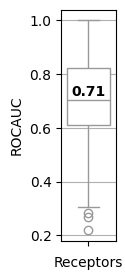

In [183]:
fig, ax = plt.subplots(figsize=(0.7, 3))
sns.boxplot(data=overall_means_df['rocauc'], color = 'white')
add_median_labels(ax)
plt.xlabel('Receptors')
plt.ylabel('ROCAUC')
plt.grid(axis = 'y')
# plt.savefig('figures/revision/2_7_1_rocauc_boxplot_lasso.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('figures/revision/2_7_1_rocauc_boxplot_lasso.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('figures/revision/2_7_1_rocauc_boxplot_lasso.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

# MWU

In [184]:
def mwu_test(receptor_binary, receptor_activity, side):
    if side == 'negative': alt = 'less'
    elif side == 'positive': alt = 'greater'
    pos = receptor_binary[receptor_binary == 1].index
    neg = receptor_binary[receptor_binary == 0].index
    pos = receptor_activity.loc[pos]
    neg = receptor_activity.loc[neg]
    if len(pos) >8: # under 8 it will be a recursion error, MWU test cannot be calculated
        u_stat, p_value = mannwhitneyu(pos.values, neg.values, alternative=alt, axis=0)
    else:
        u_stat, p_value = np.nan, 1
    return u_stat, p_value


In [185]:
def calculate_mwu_pvalues(binary, activities, side):
    receptors = list(set(activities.columns) & set(binary.columns))
    filtered_activities  = activities.loc[binary.index, receptors]
    filtered_binary = binary.loc[filtered_activities.index,receptors]

    mwu_stat = dict()
    mwu_pval = dict()
    for receptor in filtered_binary.columns:
        mwu_stat[receptor], mwu_pval[receptor] = mwu_test(filtered_binary.loc[:, receptor], filtered_activities.loc[:, receptor], side)
    return mwu_stat, mwu_pval


In [186]:

def calculate_mwustatistics(activities, prior_knowledge):

    assert activities.shape[1] != 978
    negative_binary, positive_binary = create_negativ_and_positive_binary(prior_knowledge)
    results = {}
    if len(negative_binary) != 0:
        negative_results = {}
        negative_results['mwu_stat'], negative_results['mwu_pvalue'] = calculate_mwu_pvalues(negative_binary, activities, side = 'negative')
        results['negative_results'] = negative_results
    if len(positive_binary) != 0:
        positive_results = {}
        positive_results['mwu_stat'], positive_results['mwu_pvalue'] = calculate_mwu_pvalues(positive_binary, activities, side = 'positive')
        results['positive_results'] = positive_results
    # print('---- Done ----')
    return results

In [187]:

mwu_all_results = {}
for i in tqdm(range(5)):
    results = calculate_mwustatistics(activities = receptor_activities[i], prior_knowledge = prior_knowledge.loc[test_indices_dict[i]])
    mwu_all_results[i] = results

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


In [188]:
# get all receptors
all_receptor = []
for i in mwu_all_results.keys():
    for results in mwu_all_results[i].keys():
        mwustat = mwu_all_results[i][results]['mwu_stat']
        all_receptor.extend(list(mwustat.keys()))
all_receptor = set(all_receptor)

split_list = []
direction_list = []
receptor_list = []
metric_list = []
stat_list = []
for split, results in mwu_all_results.items():
    for direction, metrics in results.items():
        if direction in ['negative_results', 'positive_results']:
            for metric, values in metrics.items():
                    for receptor, stat in values.items():
                        split_list.append(split)
                        direction_list.append(direction)
                        metric_list.append(metric)
                        receptor_list.append(receptor)
                        stat_list.append(stat)


all_results_df = pd.DataFrame({
    'Split': split_list,
    'Direction': direction_list,
    'Receptor': receptor_list,
    'Metric': metric_list, 
    'MWU_stat':stat_list
})

all_results_df = all_results_df.pivot(index = ['Split', 'Direction', 'Receptor'], columns = 'Metric', values = 'MWU_stat').reset_index()
means_df = all_results_df.groupby(['Split', 'Receptor']).agg({'mwu_pvalue':'mean', 'mwu_stat':'mean'}).reset_index()
overall_means_df = means_df.groupby(['Receptor']).agg({'mwu_pvalue':'mean', 'mwu_stat':'mean'}).reset_index()
overall_means_df = overall_means_df.sort_values(by = 'mwu_pvalue')


In [189]:
overall_means_df_notna= overall_means_df.dropna()
q1 = np.percentile(overall_means_df_notna.mwu_pvalue, 20)
q2 = np.percentile(overall_means_df_notna.mwu_pvalue, 40)  # Median
q3 = np.percentile(overall_means_df_notna.mwu_pvalue, 60)
q4 = np.percentile(overall_means_df_notna.mwu_pvalue, 80)
q1, q2, q3

(np.float64(0.10243741555067742),
 np.float64(0.303996869321714),
 np.float64(0.5))

In [190]:
def assign_confidence(value):
    if value < q1:
        return 'A'
    elif value < q2:
        return 'B'
    elif value < q3:
        return 'C'
    elif value < q4:
        return 'D'
    else:
        return 'E'
overall_means_df['Confidence'] = overall_means_df['mwu_pvalue'].apply(assign_confidence)

In [191]:
overall_means_df[(overall_means_df['Receptor'].str.contains('IFN')) | (overall_means_df['Receptor'].str.contains('PDCD1'))]

Metric,Receptor,mwu_pvalue,mwu_stat,Confidence
102,IFNGR2,2.016687e-09,96396.8,A
101,IFNGR1,9.577660e-03,87703.2,A
99,IFNAR1,1.023950e-01,91833.4,A
100,IFNAR2,1.024374e-01,97988.2,B
175,PDCD1,4.006135e-01,26915.2,C


In [192]:
overall_means_df.groupby('Confidence')['Receptor'].count()

Confidence
A    42
B    42
C    42
D    42
E    61
Name: Receptor, dtype: int64

In [193]:
overall_means_df.to_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_lasso_229_mwup_withna.csv')